# Mount Google Drive

- Mount **Google Drive** to access or save files in Colab.  
- This allows reading datasets, saving models, or exporting results directly to your Drive.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Setup & Dataset Loading

- Set seeds for **reproducibility**.  
- Load **EuroSAT RGB dataset** using `tensorflow_datasets`.  
- Print dataset **info**, **class names**, and **total number of examples**.


In [3]:
import random, os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# load dataset info
dataset_name = "eurosat/rgb"
dataset_all, info = tfds.load(dataset_name, with_info=True, as_supervised=True)
print(info)
class_names = info.features['label'].names
print("Classes:", class_names)
print("Total examples:", info.splits['train'].num_examples)


tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised

**Install Required Libraries**

This cell installs the essential Python packages for this project:

TensorFlow: For building and training deep learning models

scikit-learn: For machine learning utilities and evaluation

OpenCV: For image processing

Matplotlib: For plotting and visualization

scikit-image: For additional image processing functions

In [4]:
!pip install tensorflow scikit-learn opencv-python matplotlib scikit-image


# Feature Extraction & Random Forest

Extract features from images (grayscale stats, edges, histogram).  

Split dataset into train/test and scale features.  

Tune `RandomForestClassifier` using `RandomizedSearchCV` on a subset.  

Evaluate best model on the test set and print accuracy.


In [10]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm # Import tqdm
import cv2 # Import cv2

# Assuming train_ds is defined from data loading

# Function to extract features from one image
def extract_features(image, label):
    img = image.numpy()
    img_resized = cv2.resize(img, (64, 64))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized, (3,3), 0)
    edges = cv2.Canny(blurred, 100, 200)

    # Features
    mean_val = np.mean(equalized)
    std_val = np.std(equalized)
    edge_count = np.sum(edges > 0)   # number of edge pixels

    # Flatten histogram of grayscale image (32 bins)
    hist = cv2.calcHist([equalized], [0], None, [32], [0,256]).flatten()

    # Combine all features into one vector
    feature_vector = np.hstack([mean_val, std_val, edge_count, hist])

    return feature_vector, label.numpy()

# Extract features from dataset
X, y = [], []
# Assuming train_ds is available from previous cells
for image, label in tqdm(train_ds.take(5000)):   # limit to 5000 images for speed
    fv, lbl = extract_features(image, label)
    X.append(fv)
    y.append(lbl)

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


# Split dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------------
# 1️⃣ Scale the data
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 2️⃣ Optional: Use a subset of training data for faster tuning
# -----------------------------
X_sub, _, y_sub, _ = train_test_split(X_train_scaled, y_train, test_size=0.5, random_state=42)

# -----------------------------
# 3️⃣ Define a smaller hyperparameter search space
# -----------------------------
param_dist_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# -----------------------------
# 4️⃣ Create Random Forest model
# -----------------------------
rf_model = RandomForestClassifier(random_state=42)

# -----------------------------
# 5️⃣ RandomizedSearchCV for faster tuning
# -----------------------------
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist_rf,
    n_iter=20,            # Try 20 random combinations only
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit on subset for speed
random_search_rf.fit(X_sub, y_sub)

# -----------------------------
# 6️⃣ Print best parameters and cross-validation score
# -----------------------------
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best CV accuracy (subset) for Random Forest:", random_search_rf.best_score_)

# -----------------------------
# 7️⃣ Evaluate on full test set with best parameters
# -----------------------------
best_rf_model = random_search_rf.best_estimator_
test_accuracy_rf = best_rf_model.score(X_test_scaled, y_test)
print("Test set accuracy with best Random Forest parameters:", test_accuracy_rf)

# EuroSAT Dataset Overview

- **Description:** Satellite images from Sentinel-2 with 10 land use/cover classes and 27,000 labeled samples.  
- **Versions:**  
  - `rgb`: Only R, G, B channels (JPEG).  
  - `all`: All 13 spectral bands (float32).  
- **Image size:** 64×64×3 (RGB)  
- **Classes:** 10  
- **Dataset size:** ~89.5 MB  
- **Split:** 100% train (27,000 examples)  
- **Source:** [EuroSAT GitHub](https://github.com/phelber/eurosat)


In [11]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("eurosat/rgb", with_info=True, as_supervised=True)
train_ds = dataset['train']
print(info)


tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised

# Image Preprocessing & Visualization

- Convert images to **grayscale**, apply **histogram equalization**, **Gaussian blur**, and **Canny edge detection**.  
- Visualize the preprocessing steps for a few sample images: Original → Grayscale → Equalized → Edges.  
- Print the corresponding class labels for reference.


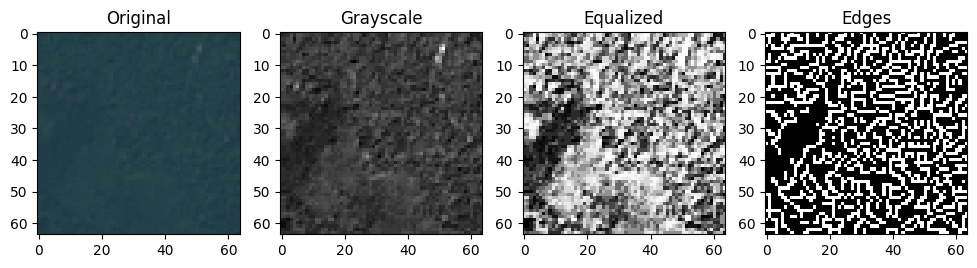

Class Label: 1


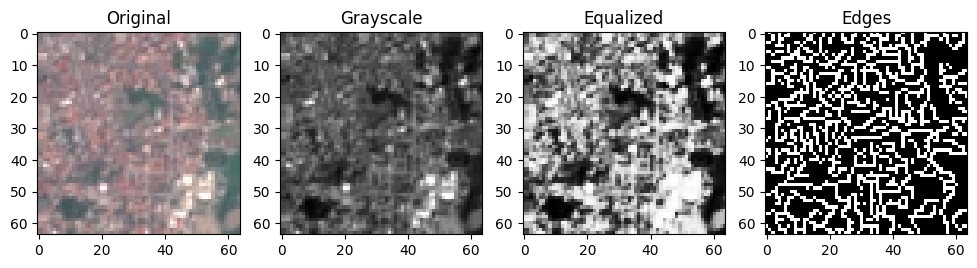

Class Label: 7


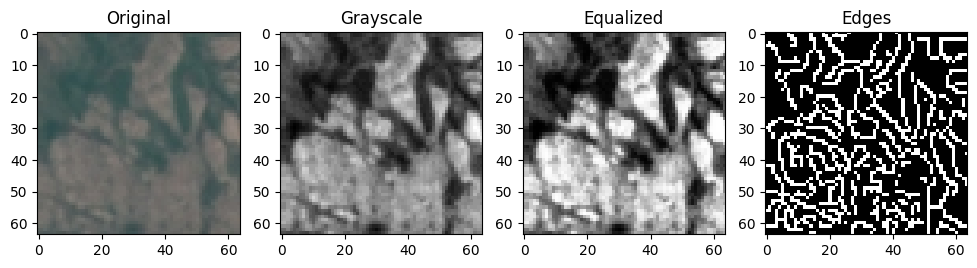

Class Label: 2


In [12]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess one image
def preprocess_image(image, label):
    # Convert TF tensor to numpy
    img = image.numpy()

    # Resize (all EuroSAT images are 64x64, but resize anyway for consistency)
    img_resized = cv2.resize(img, (64, 64))

    # Convert to grayscale
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)

    # Histogram equalization (contrast enhancement)
    equalized = cv2.equalizeHist(gray)

    # Gaussian blur (denoising)
    blurred = cv2.GaussianBlur(equalized, (3, 3), 0)

    # Edge detection (Canny)
    edges = cv2.Canny(blurred, 100, 200)

    return img_resized, gray, equalized, edges, label

# Pick a few sample images to visualize preprocessing
for image, label in train_ds.take(3):
    img_resized, gray, equalized, edges, lbl = preprocess_image(image, label)

    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    axs[0].imshow(img_resized); axs[0].set_title("Original")
    axs[1].imshow(gray, cmap="gray"); axs[1].set_title("Grayscale")
    axs[2].imshow(equalized, cmap="gray"); axs[2].set_title("Equalized")
    axs[3].imshow(edges, cmap="gray"); axs[3].set_title("Edges")
    plt.show()
    print("Class Label:", lbl.numpy())


# Feature Extraction from Images

- Preprocess images: Grayscale, equalization, blur, edge detection.  
- Extract features: mean, standard deviation, edge count, and 32-bin grayscale histogram.  
- Combine features into a single vector for each image.  
- Process a subset of 5,000 images and create feature (`X`) and label (`y`) arrays.


In [13]:
from tqdm import tqdm

# Function to extract features from one image
def extract_features(image, label):
    img = image.numpy()
    img_resized = cv2.resize(img, (64, 64))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    equalized = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(equalized, (3,3), 0)
    edges = cv2.Canny(blurred, 100, 200)

    # Features
    mean_val = np.mean(equalized)
    std_val = np.std(equalized)
    edge_count = np.sum(edges > 0)   # number of edge pixels

    # Flatten histogram of grayscale image (32 bins)
    hist = cv2.calcHist([equalized], [0], None, [32], [0,256]).flatten()

    # Combine all features into one vector
    feature_vector = np.hstack([mean_val, std_val, edge_count, hist])

    return feature_vector, label.numpy()

# Extract features from dataset
X, y = [], []
for image, label in tqdm(train_ds.take(5000)):   # limit to 5000 images for speed
    fv, lbl = extract_features(image, label)
    X.append(fv)
    y.append(lbl)

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


100%|██████████| 5000/5000 [00:07<00:00, 692.25it/s]

Feature matrix shape: (5000, 35)
Labels shape: (5000,)


# Random Forest Training & Evaluation

- Split features and labels into **train and test sets** (80/20).  
- Train a `RandomForestClassifier` on the training data.  
- Predict on the test set and compute **accuracy**.  
- Display **classification report** and **confusion matrix** for detailed evaluation.


Train set: (4000, 35)  Test set: (1000, 35)
✅ Accuracy: 0.645

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.72      0.68       116
           1       0.88      0.91      0.90       117
           2       0.44      0.41      0.42       110
           3       0.33      0.27      0.30        97
           4       0.64      0.80      0.71        93
           5       0.45      0.39      0.42        64
           6       0.43      0.34      0.38        93
           7       0.85      0.96      0.90       111
           8       0.51      0.45      0.48        89
           9       0.91      0.96      0.93       110

    accuracy                           0.65      1000
   macro avg       0.61      0.62      0.61      1000
weighted avg       0.62      0.65      0.63      1000



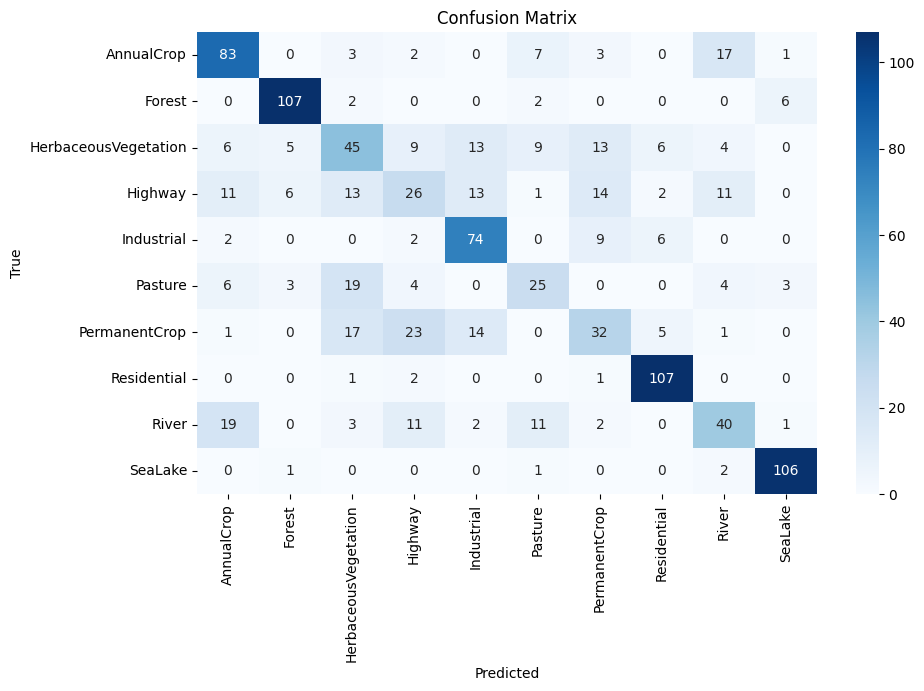

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Split dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set:", X_train.shape, " Test set:", X_test.shape)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", acc)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=info.features['label'].names, yticklabels=info.features['label'].names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Train & Evaluate Multiple Classical ML Models

- Models used:  
  - **Logistic Regression**  
  - **SVM (RBF Kernel)**  
  - **K-Nearest Neighbors (k=7, distance-weighted)**  
- Scale features using `StandardScaler`.  
- Train each model, predict on the test set, and compute **accuracy**.  
- Print a summary of accuracies for comparison.


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# -----------------------------
# 1️⃣ Define models and params
# -----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=10, gamma=0.01),
    "KNN (k=7, distance-weighted)": KNeighborsClassifier(n_neighbors=7, weights='distance')
}

# -----------------------------
# 2️⃣ Scale the features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 3️⃣ Train, predict, evaluate
# -----------------------------
results = {}

for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    # Print accuracy
    print(f"{name} Accuracy: {acc:.3f}")

# -----------------------------
# 4️⃣ Optional: show all results neatly
# -----------------------------
print("\nSummary of all models:")
for name, acc in results.items():
    print(f"{name:<25} : {acc:.3f}")


Logistic Regression Accuracy: 0.618
SVM (RBF Kernel) Accuracy: 0.608
KNN (k=7, distance-weighted) Accuracy: 0.480

Summary of all models:
Logistic Regression       : 0.618
SVM (RBF Kernel)          : 0.608
KNN (k=7, distance-weighted) : 0.480


# Hyperparameter Tuning with GridSearchCV

- Define **parameter grids** for Logistic Regression, SVM, and KNN.  
- Use `GridSearchCV` with 5-fold cross-validation to find the best hyperparameters.  
- Evaluate each best model on the test set and record accuracy.  
- Print a summary of **best parameters** and corresponding **test accuracies**.


In [16]:
from sklearn.model_selection import GridSearchCV

# -----------------------------
# 1️⃣ Define parameter grids
# -----------------------------
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs"],
        "max_iter": [1000]
    },
    "SVM (RBF Kernel)": {
        "C": [0.1, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1],
        "kernel": ["rbf"]
    },
    "KNN (k=7, distance-weighted)": { # Corrected key
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"]
    }
}

# -----------------------------
# 2️⃣ Run GridSearchCV for each model
# -----------------------------
best_results = {}

for name, model in models.items():
    print(f"Tuning {name}...")

    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy')
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)

    best_results[name] = {
        "Best Params": grid.best_params_,
        "Test Accuracy": acc
    }

    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Test Accuracy: {acc:.3f}\n")

# -----------------------------
# 3️⃣ Summary of best models
# -----------------------------
print("Summary of tuned models:")
for name, info in best_results.items():
    print(f"{name:<25} | Accuracy: {info['Test Accuracy']:.3f} | Params: {info['Best Params']}")

Tuning Logistic Regression...
Logistic Regression Best Params: {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}
Logistic Regression Test Accuracy: 0.624

Tuning SVM (RBF Kernel)...
SVM (RBF Kernel) Best Params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVM (RBF Kernel) Test Accuracy: 0.619

Tuning KNN (k=7, distance-weighted)...
KNN (k=7, distance-weighted) Best Params: {'n_neighbors': 9, 'weights': 'distance'}
KNN (k=7, distance-weighted) Test Accuracy: 0.484

Summary of tuned models:
Logistic Regression       | Accuracy: 0.624 | Params: {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}
SVM (RBF Kernel)          | Accuracy: 0.619 | Params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
KNN (k=7, distance-weighted) | Accuracy: 0.484 | Params: {'n_neighbors': 9, 'weights': 'distance'}


# Evaluate Best Logistic Regression Model

- Train the best Logistic Regression model with tuned hyperparameters.  
- Predict on the test set.  
- Display **confusion matrix** and **classification report** for detailed evaluation.


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

best_model = LogisticRegression(C=100, max_iter=1000, solver='lbfgs')
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 85   0   4   4   0   4   5   0  13   1]
 [  0 112   1   0   0   0   0   1   2   1]
 [  7   3  37  14  12   7  15  11   4   0]
 [ 12   5  11  30  15   4  17   1   2   0]
 [  2   0   4   1  65   0  13   8   0   0]
 [ 13   1  16   5   0  22   0   0   7   0]
 [  2   0  16  17  19   0  34   5   0   0]
 [  0   0   2   0   1   0   0 108   0   0]
 [ 29   0   3  16   1  12   4   0  23   1]
 [  1   0   0   0   0   1   0   0   0 108]]
              precision    recall  f1-score   support

           0       0.56      0.73      0.64       116
           1       0.93      0.96      0.94       117
           2       0.39      0.34      0.36       110
           3       0.34      0.31      0.33        97
           4       0.58      0.70      0.63        93
           5       0.44      0.34      0.39        64
           6       0.39      0.37      0.38        93
           7       0.81      0.97      0.88       111
           8       0.45      0.26      0.33        89
           9       0.97     

# Soft Voting Ensemble

- Define **Logistic Regression**, **SVM**, and **KNN** models with class balancing.  
- Combine models using a **soft voting ensemble**.  
- Train the ensemble on scaled training data.  
- Predict on the test set and evaluate with **confusion matrix**, **classification report**, and overall **accuracy**.


In [18]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1️⃣ Define models with class balancing
# -----------------------------
logreg = LogisticRegression(C=100, max_iter=1000, solver='lbfgs', class_weight='balanced')
svm = SVC(C=100, gamma=0.001, kernel='rbf', class_weight='balanced', probability=True)
knn = KNeighborsClassifier(n_neighbors=9, weights='distance')

# -----------------------------
# 2️⃣ Create a voting ensemble
# -----------------------------
ensemble = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('svm', svm),
        ('knn', knn)
    ],
    voting='soft'  # uses predicted probabilities
)

# -----------------------------
# 3️⃣ Train ensemble
# -----------------------------
ensemble.fit(X_train_scaled, y_train)

# -----------------------------
# 4️⃣ Predict & evaluate
# -----------------------------
y_pred = ensemble.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# -----------------------------
# 5️⃣ Accuracy
# -----------------------------
accuracy = ensemble.score(X_test_scaled, y_test)
print(f"Ensemble Test Accuracy: {accuracy:.3f}")


Confusion Matrix:
[[ 87   0   2   3   0   3   6   0  14   1]
 [  0 106   4   0   0   2   0   1   3   1]
 [  5   2  42  11  17   7  15   8   3   0]
 [ 10   5   9  23  19   3  19   1   8   0]
 [  3   0   3   1  74   0   6   6   0   0]
 [ 12   2  12   9   1  20   2   0   6   0]
 [  3   0  13  14  20   0  39   4   0   0]
 [  0   0   2   0   1   0   0 108   0   0]
 [ 23   0   2  13   1  15   5   0  29   1]
 [  1   0   0   0   0   2   0   0   0 107]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67       116
           1       0.92      0.91      0.91       117
           2       0.47      0.38      0.42       110
           3       0.31      0.24      0.27        97
           4       0.56      0.80      0.65        93
           5       0.38      0.31      0.34        64
           6       0.42      0.42      0.42        93
           7       0.84      0.97      0.90       111
           8       0.46      0.33      0

# Soft Voting Ensemble with SMOTE

- Apply **SMOTE** to balance the training dataset.  
- Define **Logistic Regression**, **SVM**, and **KNN** models.  
- Train a **soft voting ensemble** on the resampled data.  
- Predict on the test set and evaluate with **confusion matrix**, **classification report**, and overall **accuracy** after SMOTE.


In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 1️⃣ Apply SMOTE to training data
# -----------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# -----------------------------
# 2️⃣ Define models with class balancing (optional now since SMOTE is applied)
# -----------------------------
logreg = LogisticRegression(C=100, max_iter=1000, solver='lbfgs')
svm = SVC(C=100, gamma=0.001, kernel='rbf', probability=True)
knn = KNeighborsClassifier(n_neighbors=9, weights='distance')

# -----------------------------
# 3️⃣ Create a voting ensemble
# -----------------------------
ensemble_smote = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('svm', svm),
        ('knn', knn)
    ],
    voting='soft'
)

# -----------------------------
# 4️⃣ Train ensemble on resampled data
# -----------------------------
ensemble_smote.fit(X_train_res, y_train_res)

# -----------------------------
# 5️⃣ Predict & evaluate
# -----------------------------
y_pred_smote = ensemble_smote.predict(X_test_scaled)

print("Confusion Matrix after SMOTE:")
print(confusion_matrix(y_test, y_pred_smote))

print("\nClassification Report after SMOTE:")
print(classification_report(y_test, y_pred_smote))

accuracy_smote = ensemble_smote.score(X_test_scaled, y_test)
print(f"Ensemble Test Accuracy after SMOTE: {accuracy_smote:.3f}")


Confusion Matrix after SMOTE:
[[ 78   0   2   5   0   8   7   0  15   1]
 [  0 108   2   0   0   4   0   1   1   1]
 [  3   2  33  12  19  14  14   8   5   0]
 [ 10   5   6  23  19   5  20   1   8   0]
 [  2   0   2   2  71   0  11   5   0   0]
 [  3   2   7   7   1  34   4   0   6   0]
 [  2   0   8  16  24   1  38   4   0   0]
 [  0   0   2   0   1   0   0 108   0   0]
 [ 18   0   2  13   1  14   6   0  34   1]
 [  1   1   0   0   0   2   0   0   0 106]]

Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       116
           1       0.92      0.92      0.92       117
           2       0.52      0.30      0.38       110
           3       0.29      0.24      0.26        97
           4       0.52      0.76      0.62        93
           5       0.41      0.53      0.47        64
           6       0.38      0.41      0.39        93
           7       0.85      0.97      0.91       111
           8    

# Confusion Matrix of Final Ensemble

- Visualize the **confusion matrix** of the SMOTE-trained voting ensemble.  
- Use a **heatmap** for clear representation of true vs predicted classes.


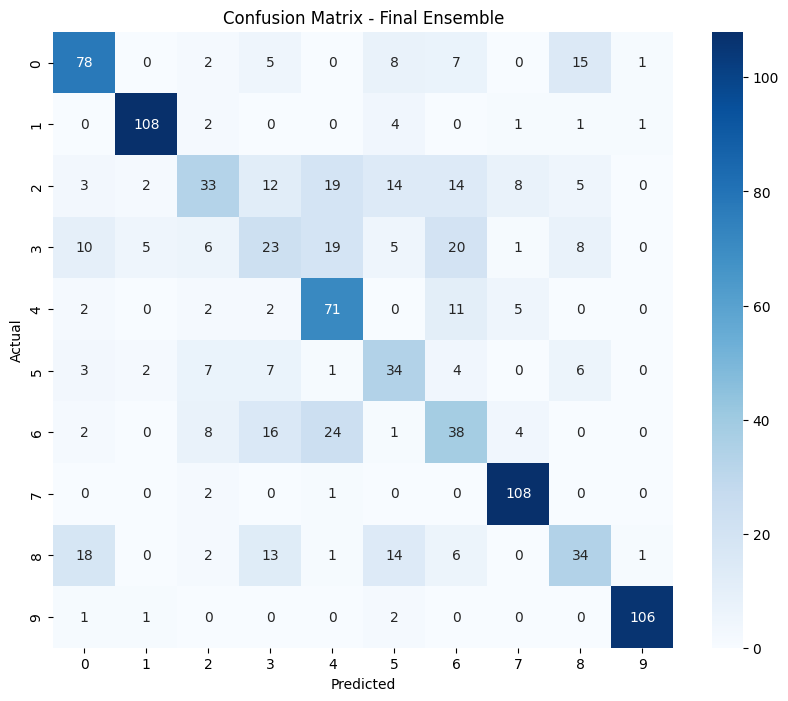

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix of final ensemble
cm = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final Ensemble")
plt.show()


# Traditional ML Models: Training, Tuning & Evaluation

- Define **Logistic Regression**, **SVM**, and **KNN** models.  
- Scale features with `StandardScaler`.  
- Train initial models and evaluate **accuracy**.  
- Perform **GridSearchCV** for hyperparameter tuning.  
- Evaluate the best Logistic Regression model with **confusion matrix** and **classification report**.  
- Summarize **tuned models’ best parameters and test accuracies**.


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Define models and initial params
# -----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=10, gamma=0.01),
    "KNN (k=7, distance-weighted)": KNeighborsClassifier(n_neighbors=7, weights='distance')
}

# -----------------------------
# 2️⃣ Scale the features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 3️⃣ Train, predict, evaluate initial models
# -----------------------------
results = {}

print("Initial Model Evaluation:")
for name, model in models.items():
    # Fit the model
    model.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    # Print accuracy
    print(f"{name} Accuracy: {acc:.3f}")

# -----------------------------
# 4️⃣ Define parameter grids for tuning
# -----------------------------
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs"],
        "max_iter": [1000]
    },
    "SVM (RBF Kernel)": {
        "C": [0.1, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1],
        "kernel": ["rbf"]
    },
    "KNN (k=7, distance-weighted)": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"]
    }
}

# -----------------------------
# 5️⃣ Run GridSearchCV for each model
# -----------------------------
best_results = {}

print("\nTuning Traditional Models with GridSearchCV:")
for name, model in models.items():
    print(f"Tuning {name}...")

    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy')
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)

    best_results[name] = {
        "Best Params": grid.best_params_,
        "Test Accuracy": acc
    }

    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Test Accuracy: {acc:.3f}\n")

# -----------------------------
# 6️⃣ Evaluate best Logistic Regression model in detail
# -----------------------------
print("\nDetailed Evaluation of Best Logistic Regression Model:")
best_logreg_model = LogisticRegression(C=100, max_iter=1000, solver='lbfgs')
best_logreg_model.fit(X_train_scaled, y_train)
y_pred_logreg = best_logreg_model.predict(X_test_scaled)

print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_logreg))

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg))

# -----------------------------
# 7️⃣ Summary of tuned models
# -----------------------------
print("Summary of tuned models:")
for name, info in best_results.items():
    print(f"{name:<25} | Accuracy: {info['Test Accuracy']:.3f} | Params: {info['Best Params']}")


Initial Model Evaluation:
Logistic Regression Accuracy: 0.618
SVM (RBF Kernel) Accuracy: 0.608
KNN (k=7, distance-weighted) Accuracy: 0.480

Tuning Traditional Models with GridSearchCV:
Tuning Logistic Regression...
Logistic Regression Best Params: {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}
Logistic Regression Test Accuracy: 0.624

Tuning SVM (RBF Kernel)...
SVM (RBF Kernel) Best Params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVM (RBF Kernel) Test Accuracy: 0.619

Tuning KNN (k=7, distance-weighted)...
KNN (k=7, distance-weighted) Best Params: {'n_neighbors': 9, 'weights': 'distance'}
KNN (k=7, distance-weighted) Test Accuracy: 0.484


Detailed Evaluation of Best Logistic Regression Model:
Confusion Matrix (Logistic Regression):
[[ 85   0   4   4   0   4   5   0  13   1]
 [  0 112   1   0   0   0   0   1   2   1]
 [  7   3  37  14  12   7  15  11   4   0]
 [ 12   5  11  30  15   4  17   1   2   0]
 [  2   0   4   1  65   0  13   8   0   0]
 [ 13   1  16   5   0  22   0   0   

# Voting Ensemble with and without SMOTE

- Define **Logistic Regression**, **SVM**, and **KNN** using best parameters.  
- Train a **soft voting ensemble** on original training data and evaluate.  
- Apply **SMOTE** to balance the training set.  
- Train the voting ensemble on resampled data and evaluate on test set.  
- Display **confusion matrix** and **classification report** for both cases, including a heatmap for the final ensemble with SMOTE.


Evaluating Voting Ensemble (without SMOTE):
Confusion Matrix:
[[ 89   0   3   3   0   3   5   0  12   1]
 [  0 110   3   0   0   0   0   1   2   1]
 [  6   4  42  11  17   5  13   9   3   0]
 [ 11   5  11  23  19   3  18   1   6   0]
 [  3   0   3   1  74   0   6   6   0   0]
 [ 13   2  14   8   1  16   3   0   7   0]
 [  4   0  15  15  20   0  35   4   0   0]
 [  0   0   2   0   1   0   0 108   0   0]
 [ 27   0   3  13   1  13   5   0  26   1]
 [  1   0   0   0   0   1   0   0   0 108]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.77      0.66       116
           1       0.91      0.94      0.92       117
           2       0.44      0.38      0.41       110
           3       0.31      0.24      0.27        97
           4       0.56      0.80      0.65        93
           5       0.39      0.25      0.30        64
           6       0.41      0.38      0.39        93
           7       0.84      0.97      0.90       

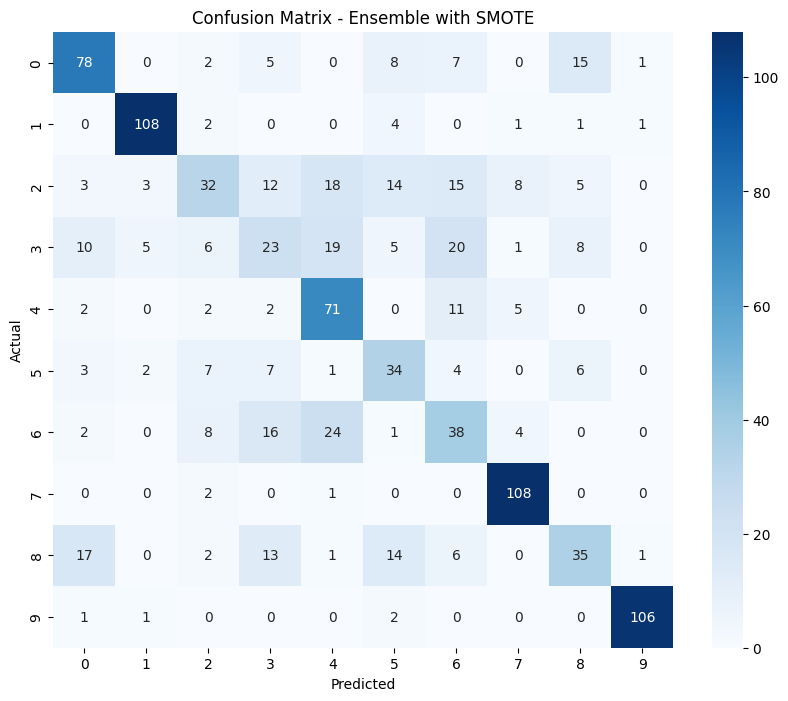

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Define models for the ensemble
# -----------------------------
# Using best parameters from GridSearchCV
logreg = LogisticRegression(C=100, max_iter=1000, solver='lbfgs')
svm = SVC(C=100, gamma=0.001, kernel='rbf', probability=True) # probability=True needed for soft voting
knn = KNeighborsClassifier(n_neighbors=9, weights='distance')

# -----------------------------
# 2️⃣ Create a voting ensemble (without SMOTE)
# -----------------------------
ensemble = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('svm', svm),
        ('knn', knn)
    ],
    voting='soft'  # uses predicted probabilities
)

# -----------------------------
# 3️⃣ Train and evaluate ensemble (without SMOTE)
# -----------------------------
print("Evaluating Voting Ensemble (without SMOTE):")
ensemble.fit(X_train_scaled, y_train)
y_pred_ensemble = ensemble.predict(X_test_scaled)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))

accuracy_ensemble = ensemble.score(X_test_scaled, y_test)
print(f"Ensemble Test Accuracy: {accuracy_ensemble:.3f}\n")

# -----------------------------
# 4️⃣ Apply SMOTE to training data
# -----------------------------
print("Applying SMOTE and Evaluating Voting Ensemble:")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# -----------------------------
# 5️⃣ Define models for the ensemble (optional class_weight since SMOTE applied)
# -----------------------------
logreg_smote = LogisticRegression(C=100, max_iter=1000, solver='lbfgs')
svm_smote = SVC(C=100, gamma=0.001, kernel='rbf', probability=True)
knn_smote = KNeighborsClassifier(n_neighbors=9, weights='distance')

# -----------------------------
# 6️⃣ Create a voting ensemble (with SMOTE)
# -----------------------------
ensemble_smote = VotingClassifier(
    estimators=[
        ('logreg', logreg_smote),
        ('svm', svm_smote),
        ('knn', knn_smote)
    ],
    voting='soft'
)

# -----------------------------
# 7️⃣ Train and evaluate ensemble on resampled data (with SMOTE)
# -----------------------------
ensemble_smote.fit(X_train_res, y_train_res)
y_pred_smote = ensemble_smote.predict(X_test_scaled)

print("Confusion Matrix after SMOTE:")
print(confusion_matrix(y_test, y_pred_smote))

print("\nClassification Report after SMOTE:")
print(classification_report(y_test, y_pred_smote))

accuracy_smote = ensemble_smote.score(X_test_scaled, y_test)
print(f"Ensemble Test Accuracy after SMOTE: {accuracy_smote:.3f}\n")

# -----------------------------
# 8️⃣ Plot Confusion Matrix of the final ensemble (with SMOTE)
# -----------------------------
cm_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(10,8))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ensemble with SMOTE")
plt.show()


# CNN on EuroSAT Dataset

- Load EuroSAT RGB images and resize to 64×64.  
- Normalize images and one-hot encode labels (10 classes).  
- Define a **Sequential CNN**:  
  - 2 Conv2D + MaxPooling layers  
  - Flatten → Dense(128) + Dropout → Output Dense(10) with softmax  
- Compile with **Adam optimizer** and **categorical crossentropy**.  
- Train for 10 epochs with validation split and evaluate test accuracy.


In [25]:
# ✅ CNN Implementation on EuroSAT dataset in one cell

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow_datasets as tfds

# -------------------------------
# 1️⃣ Load EuroSAT dataset
# -------------------------------
dataset, info = tfds.load("eurosat/rgb", with_info=True, as_supervised=True)
data = list(tfds.as_numpy(dataset['train']))

X = np.array([cv2.resize(img, (64, 64)) for img, _ in data])  # ensure 64x64 size
y = np.array([label for _, label in data])

# Normalize images
X = X.astype("float32") / 255.0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# One-hot encode labels (10 classes for EuroSAT RGB)
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# -------------------------------
# 2️⃣ Define CNN Model
# -------------------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# -------------------------------
# 3️⃣ Compile Model
# -------------------------------
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# -------------------------------
# 4️⃣ Train Model
# -------------------------------
history = model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=2
)

# -------------------------------
# 5️⃣ Evaluate on Test Data
# -------------------------------
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print("✅ CNN Test Accuracy:", test_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
270/270 - 107s - 396ms/step - accuracy: 0.4503 - loss: 1.4496 - val_accuracy: 0.6065 - val_loss: 1.1499
Epoch 2/10
270/270 - 93s - 345ms/step - accuracy: 0.6401 - loss: 1.0249 - val_accuracy: 0.7146 - val_loss: 0.7970
Epoch 3/10
270/270 - 140s - 520ms/step - accuracy: 0.7011 - loss: 0.8433 - val_accuracy: 0.7613 - val_loss: 0.6665
Epoch 4/10
270/270 - 94s - 346ms/step - accuracy: 0.7315 - loss: 0.7589 - val_accuracy: 0.7806 - val_loss: 0.6166
Epoch 5/10
270/270 - 141s - 522ms/step - accuracy: 0.7529 - loss: 0.7015 - val_accuracy: 0.7956 - val_loss: 0.5824
Epoch 6/10
270/270 - 149s - 554ms/step - accuracy: 0.7641 - loss: 0.6646 - val_accuracy: 0.7993 - val_loss: 0.5596
Epoch 7/10
270/270 - 145s - 536ms/step - accuracy: 0.7803 - loss: 0.6206 - val_accuracy: 0.7921 - val_loss: 0.5754
Epoch 8/10
270/270 - 144s - 533ms/step - accuracy: 0.7964 - loss: 0.5748 - val_accuracy: 0.7898 - val_loss: 0.5841
Epoch 9/10
270/270 - 135s - 500ms/step - accuracy: 0.8119 - loss: 0.5324 - val_acc

# Prepare EuroSAT Dataset for CNN

- Load **EuroSAT RGB** dataset and retrieve dataset info.  
- Define preprocessing: convert images to `float32` and normalize.  
- Split dataset into **train (80%)**, **validation (10%)**, and **test (10%)**.  
- Cache, shuffle, batch (32), and prefetch datasets for efficient training.  
- Print sizes of train, validation, and test sets.


In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds # Import tfds

# Load dataset info and the dataset
dataset_name = "eurosat/rgb"
dataset_all, info = tfds.load(dataset_name, with_info=True, as_supervised=True) # Load dataset and info

# 1. Define preprocessing function
def preprocess_cnn(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) # Convert to float32 and normalize
    return image, label

# 2. Define image size and batch size
IMG_WIDTH = 64
IMG_HEIGHT = 64
BATCH_SIZE = 32

# Get the total number of examples from the previously loaded info object
total_examples = info.splits['train'].num_examples

# Define split percentages
train_split_percent = 0.8
val_split_percent = 0.1
test_split_percent = 0.1

# Calculate the number of examples for each split
train_size = int(train_split_percent * total_examples)
val_size = int(val_split_percent * total_examples)
test_size = total_examples - train_size - val_size # Ensure total is correct

# 4. Split the dataset
train_ds = dataset_all['train'].take(train_size)
val_ds = dataset_all['train'].skip(train_size).take(val_size)
test_ds = dataset_all['train'].skip(train_size + val_size).take(test_size)

# 5. Apply preprocessing
train_ds = train_ds.map(preprocess_cnn)
val_ds = val_ds.map(preprocess_cnn)
test_ds = test_ds.map(preprocess_cnn)

# 6. Cache, shuffle, and batch the training dataset
train_ds = train_ds.cache().shuffle(buffer_size=train_size).batch(BATCH_SIZE)

# 7. Cache and batch the validation and test datasets
val_ds = val_ds.cache().batch(BATCH_SIZE)
test_ds = test_ds.cache().batch(BATCH_SIZE)

# 8. Use prefetch
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")
print(f"Test dataset size: {test_size}")

Train dataset size: 21600
Validation dataset size: 2700
Test dataset size: 2700


# Model Accuracy Comparison

- Visualize and compare **accuracies** of different models using a **bar plot**.  
- Models include Logistic Regression, SVM, KNN, Voting Ensemble, and Voting Ensemble with SMOTE.  
- Helps identify the **best performing model** at a glance.


/tmp/ipython-input-3611510610.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=summary, palette="viridis")


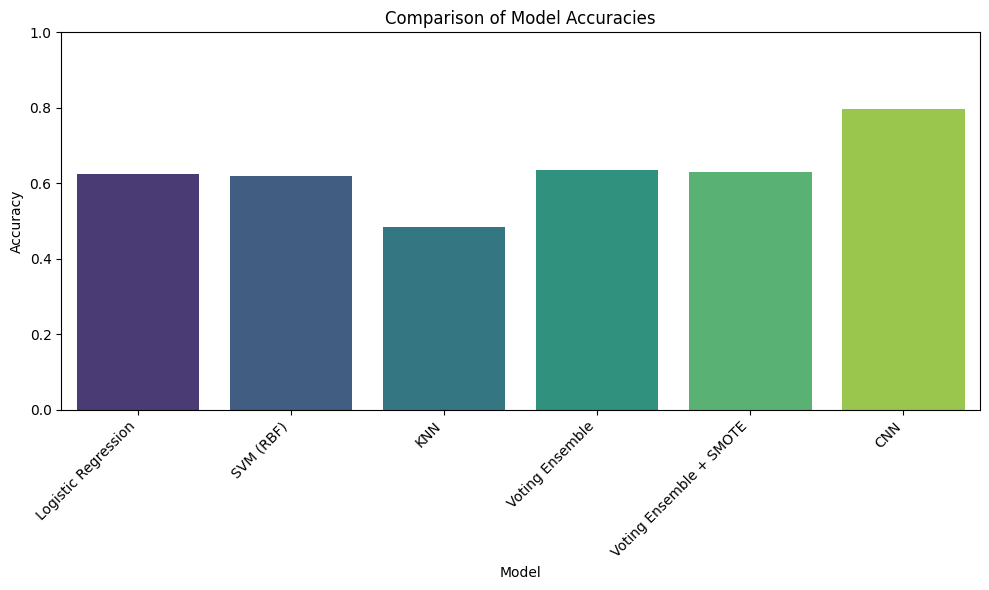

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming the 'summary' DataFrame is available from a previous cell
# If not, recreate it or ensure the cell defining it is executed:
# summary = pd.DataFrame({
#     "Model": ["Logistic Regression", "SVM (RBF)", "KNN", "Voting Ensemble", "Voting Ensemble + SMOTE"],
#     "Accuracy": [0.624, 0.619, 0.484, 0.635, 0.630], # Replace with actual accuracies from your runs
#     "Best Params": [...] # Add best params if you want to display them
# })

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=summary, palette="viridis")
plt.title("Comparison of Model Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# Summary of All Models

- Create a **DataFrame** summarizing all models: Logistic Regression, SVM, KNN, Voting Ensembles, and CNN.  
- Include **accuracy** and **best parameters** or model details.  
- Provides a quick overview for comparison of performance across models.


In [28]:
import pandas as pd

# Assuming test_acc from the CNN evaluation is available
summary = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM (RBF)", "KNN", "Voting Ensemble", "Voting Ensemble + SMOTE", "CNN"],
    "Accuracy": [0.624, 0.619, 0.484, 0.635, 0.630, test_acc], # Added CNN accuracy
    "Best Params": [
        "{'C':100, 'max_iter':1000, 'solver':'lbfgs'}",
        "{'C':100, 'gamma':0.001, 'kernel':'rbf'}",
        "{'n_neighbors':9, 'weights':'distance'}",
        "Voting soft ensemble",
        "Voting soft ensemble on SMOTE data",
        "Default CNN architecture (see code)" # Added CNN params placeholder
    ]
})

print(summary)

                     Model  Accuracy  \
0      Logistic Regression  0.624000   
1                SVM (RBF)  0.619000   
2                      KNN  0.484000   
3          Voting Ensemble  0.635000   
4  Voting Ensemble + SMOTE  0.630000   
5                      CNN  0.796667   

                                    Best Params  
0  {'C':100, 'max_iter':1000, 'solver':'lbfgs'}  
1      {'C':100, 'gamma':0.001, 'kernel':'rbf'}  
2       {'n_neighbors':9, 'weights':'distance'}  
3                          Voting soft ensemble  
4            Voting soft ensemble on SMOTE data  
5           Default CNN architecture (see code)  
